In [1]:
#importing libraries

import numpy as np 
import tensorflow as tf
import helper

C:\Users\gsund\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
helper.download_dataset()
train_images, train_labels, validation_images, validation_labels, test_images, test_labels = helper.load_data()
train_images, validation_images, test_images = helper.reshape(train_images), helper.reshape(validation_images), helper.reshape(test_images)

Getting MNIST Dataset...
Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Data Extracted.


### Syntax:

- tf.layers.conv2d(
    inputs,
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format='channels_last',
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer(),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    trainable=True,
    name=None,
    reuse=None
)

- tf.layers.max_pooling2d(
    inputs,
    pool_size,
    strides,
    padding='valid',
    data_format='channels_last',
    name=None
)

- tf.image.resize_nearest_neighbor(
    images,
    size,
    align_corners=False,
    name=None
)

### formulas for convolution and pooling

1. Formula for calculating the new dimensions wrt convolution
    - When Padding is 'SAME'
        1. new_height = ceil( float(input_height) / float(strides[height]) )
        2. new_width = ceil( float(input_width) / float(strides[widht]) )
    - When Padding is 'VALID'
        1. new_height = ceil( float(input_height - filter_height + 1) / float(strides[height]) )
        2. new_width = ceil( float(input_width - filter_width + 1) / float(strides[width]) )
<br><br>         
2. Formula for calculating the new dimensions wrt max pooling
    - new_height = ( (input_height - filter_height) / stride[height] ) + 1
    - new_width = ( (input_width - filter_width) / stride[width] ) + 1


In [3]:
inputs = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32, name="inputs" )
targets = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32, name="targets")

#encoding
conv1 = tf.layers.conv2d(inputs=inputs, filters=16, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 28x28x16
maxpooling1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2, 2), strides=(2, 2), padding='SAME')
#result : 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpooling1, filters=8, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 14x14x8
maxpooling2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
#result : 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpooling2, filters=8, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 7x7x8
encoded = tf.layers.conv2d(inputs=conv3, filters=8, kernel_size=(2, 2), strides=(2, 2), padding='SAME')
#result : 4x4x8

#Decoding
#Note: use upsampling and then conv layer, This technique yeilds better results
#upsampling
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
#result : 7x7x8
conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
#result : 14x14x8
conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
#result : 28x28x8
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=tf.nn.relu)
#result : 28x28x16
logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation=None)

decoded = tf.nn.sigmoid(logits, name='outputs')
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [4]:
#hyper parameters
epochs = 20
batch_size = 256

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(epochs):
        for ii in range(0, len(train_images), batch_size):
            batch_images = train_images[ii: ii + batch_size]
            feed = {
                inputs : batch_images,
                targets : batch_images
            }
            cost_ , _ = sess.run([cost, optimizer], feed_dict=feed)
            
            print("Epoch {}/{} ...".format(epoch+1, epochs),
                 "Training Loss {:0.3f}".format(cost_))
    saver.save(sess, "./cnn_autoencoder.ckpt")

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

INFO:tensorflow:Restoring parameters from ./cnn_autoencoder.ckpt


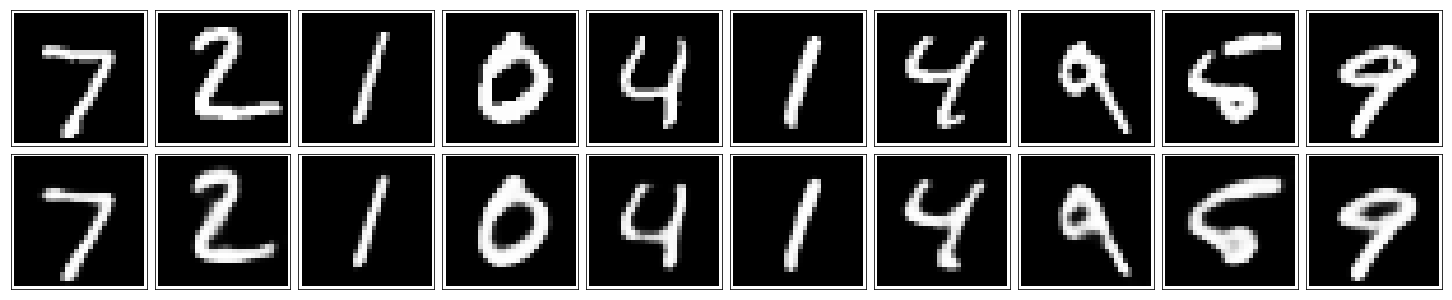

In [7]:
#comparing the original images with the reconstructed images

in_imgs = test_images[:10]
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./cnn_autoencoder.ckpt")
    reconstructed = sess.run(decoded, feed_dict={
        inputs: in_imgs
    })

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)